# Old faithful geyser data

Sources: [curran geyser.tsv](https://gist.github.com/curran/4b59d1046d9e66f2787780ad51a1cd87#file-data-tsv)
and [seaborn geyser](https://github.com/mwaskom/seaborn-data/blob/master/geyser.csv)


In [74]:
from mixes import Evaluator, GMN, DGMM, SkewGMM, GMM
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolor
from sklearn import preprocessing
import os

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


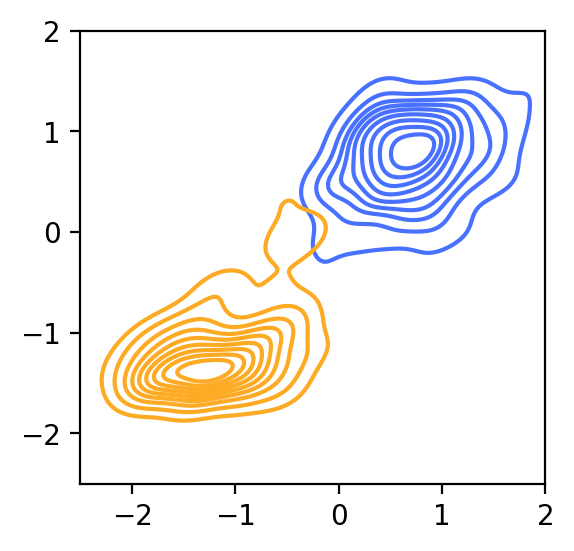

In [75]:
# np.random.seed(2000)
n_samples = 2000

geyser = sns.load_dataset("geyser")
data = geyser[["waiting", "duration"]].values
data = preprocessing.scale(data)
geyser[["waiting", "duration"]] = data

xlim = [-2.5, 2]
ylim = [-2.5, 2]

evaluator = Evaluator(data=data, print_metrics=False)
colors = [pltcolor.hex2color("#4871ff"), pltcolor.hex2color("#fdaa24")]

def dist_plot(data, clusters):
    cluster_i = np.sort(np.unique(clusters))
    for i in range(len(cluster_i)):
        values = data[clusters == cluster_i[i]]
        sns.kdeplot(x=values[:,0], y=values[:,1], color=colors[i])
    plt.xlim(xlim)
    plt.ylim(ylim)

def train_algorithm(alg):
    alg.fit(data)
    alg_result = evaluator.get_result()

    alg_values, alg_dists = alg.random_sample(n_samples)
    alg_fig = plt.figure(figsize=(3, 3), dpi=200)
    dist_plot(alg_values, alg_dists)

    plt.show()

    print(alg_result)
    return alg_fig, alg_result

data_fig = plt.figure(figsize=(3, 3), dpi=200)
# sns.kdeplot(data=geyser, x="waiting", y="duration", hue="kind")
dist_plot(data, geyser["kind"].values)
plt.show()

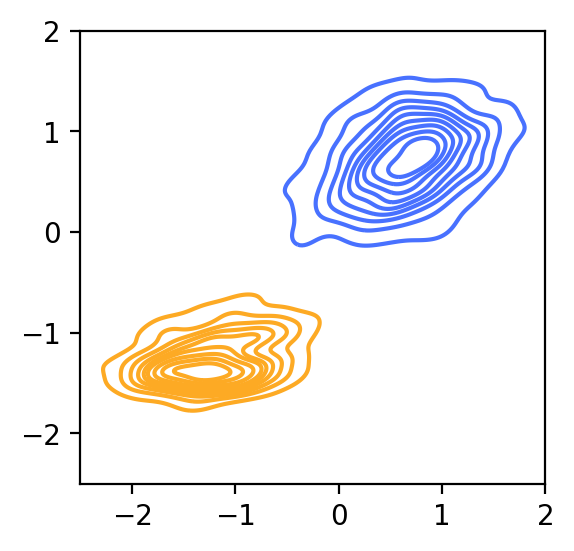

log_lik   -367.554948
Name: 200, dtype: float64


In [76]:
gmn = GMN([2, 5], [2, 1], num_iter=200, update_rate=0.1, init='kmeans',
          evaluator=evaluator)
gmn_fig, gmn_result = train_algorithm(gmn)

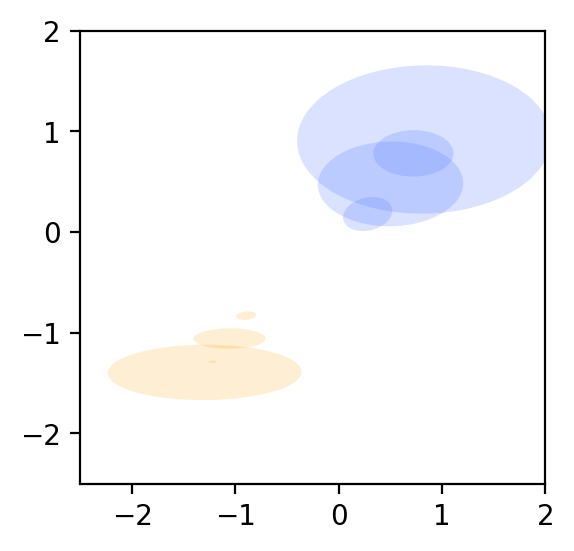

In [78]:
gmn_paths_fig = plt.figure(figsize=(3, 3), dpi=200)
plt.xlim(xlim)
plt.ylim(ylim)
gmn.plot_distributions(data, use_pi=True, colors=colors)
plt.gca().set_aspect('auto')
plt.title('');

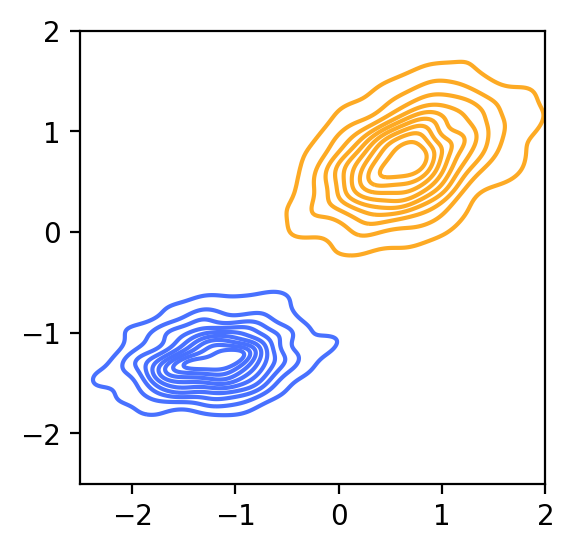

log_lik   -385.460696
Name: 100, dtype: float64


In [79]:
gmm = GMM(2, init='random', num_iter=100, update_rate=1,
          evaluator=evaluator)
gmm_fig, gmm_result = train_algorithm(gmm)

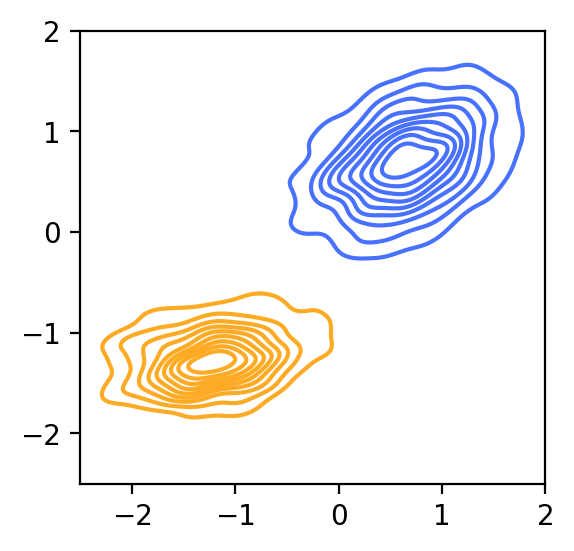

log_lik   -384.321045
Name: 100, dtype: float64


In [82]:
skew = SkewGMM(2, num_iter=100, evaluator=evaluator, update_rate=0.2)
skew_fig, skew_result = train_algorithm(skew)

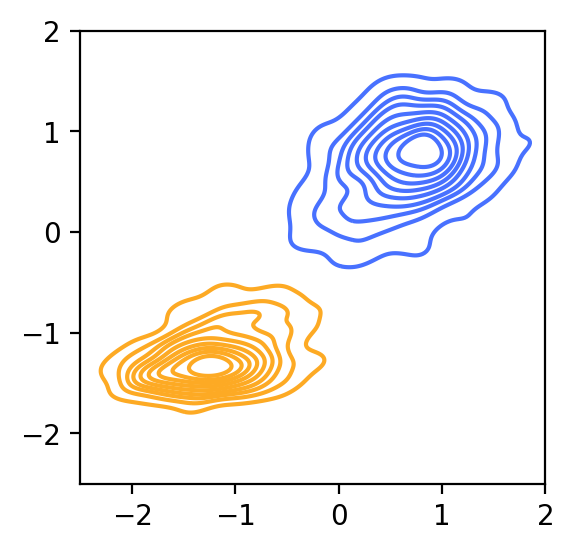

log_lik   -372.630969
Name: 200, dtype: float64


In [80]:
dgmm = DGMM([2, 5], [2, 1], num_iter=200, update_rate=0.1, init='kmeans',
            evaluator=evaluator)
dgmm_fig, dgmm_result = train_algorithm(dgmm)

In [83]:
dir_i = 7
out_dir = "../../experiment-results/geyser-experiment-%d" % dir_i
os.makedirs(out_dir, exist_ok=True)

data_fig.savefig("%s/true.png" % out_dir)
gmm_fig.savefig("%s/gmm.png" % out_dir)
gmn_fig.savefig("%s/gmn.png" % out_dir)
dgmm_fig.savefig("%s/dgmm.png" % out_dir)
skew_fig.savefig("%s/skew.png" % out_dir)
gmn_paths_fig.savefig("%s/paths.png" % out_dir)

In [84]:
result = pd.DataFrame(pd.concat([gmm_result, skew_result, gmn_result, dgmm_result]))
result.index = ["GMM", "Skew GMM", "GMN", "DGMM"]
result.columns = ["log likelihood"]
result

,log likelihood
GMM,-385.460696
Skew GMM,-384.321045
GMN,-367.554948
DGMM,-372.630969
